# Деревья решений

Идея: давайте разделять пространство признаков на области по условию $sign(x_i - th_i)$, для каждой области либо вернем ответ, либо повторим процедуру.

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
iris = load_iris()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

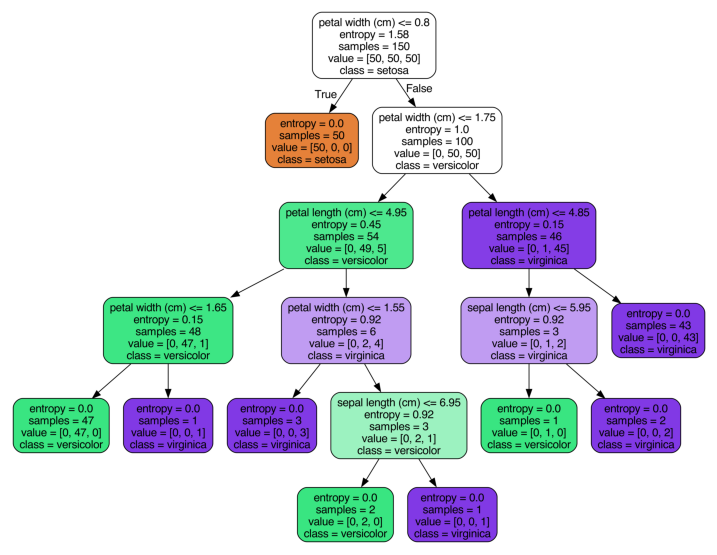

In [3]:
from sklearn.tree import export_graphviz
from subprocess import call


def create_tree_image(clf):
    export_graphviz(
        clf,
        out_file='tree.dot',
        feature_names=iris.feature_names,
        class_names=iris.target_names,
        rounded=True, 
        proportion=False,
        precision=2,
        filled = True,
    )

    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

    # Display in python
    plt.figure(figsize = (9, 7))
    plt.imshow(plt.imread('tree.png'))
    plt.axis('off');
    plt.show();
    

dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)
dt.fit(iris.data, iris.target)
create_tree_image(dt)

## Вопросы
1. Как вернуть ответ для конкретной области?
2. Как подбирать порог для разбиения?
3. Когда останавливаться?

## Как вернуть ответ для конкретной области?
Фактически, надо построить константное предсказание, оптимальное для минимазции функции ошибки на объектах, попавших в данный лист дерева.
Задача построения константного предсказания часто имеет аналитическое решение.

1. Для задачи регрессии с квадратичной функцией потерь (MSE) — это среднее значение целевой функции.
2. Для задачи регрессии с абсолютной ошибкой (MAE) — это медианное значние целевое функции.
3. Для задачи бинарной классификации с функцией ошибки LogLoss — это доля объетов первого класса.

**Упраженение** Докажите утверждения 1—3.

## Как подбирать порог для разбиения?
Хотим сделать так, чтобы выборки в каждом из листов оказались как можно более однородны — тогда констаное предсказание будет работать лучше всего.
Пусть у нас есть некторый критерий, который оценивает неоднородность выборки — *impurity criteria*. 
Тогда мы можем оценивать *информационный выигрыш (прирост информации, informaion gain)*, как 
$$
    IG = R - \sum\limits_{i=1}^{k} \frac{N_i}{N} R_i,
$$
где $R$ — значение критерия на всех данных, $N_i$ — число объектов в $i$-ой группе, $R_i$ — значение критерия на $i$-ой группе.

### Для задачи регрессии 
Минимизируем дисперсию в каждом из листьев.

### Энтропийный критерий
Пусть есть система с $n$ состояниями и система находится в $i$-ом состоянии в вероятностью $p_i$.

*Энтропией (Шенона)* такой системы называется величина 
$$
    H(\mathbf{p}) = -\sum_\limits{i=1}^n p_i\log p_i.
$$

Свойства энтропии:
1. $H(\mathbf{p}) \geq 0$
2. $H(\mathbf{p}) \leq \log n$, при этом $H(\mathbf{p}) = \log n \Leftrightarrow p_i = \frac{1}{n}, i = 1, 2, \ldots, n.$

*Доказательство* 
$H(\mathbf{p}) = -\sum\limits_{i=1}^n p_i\log p_i = 
\sum\limits_{i=1}^n p_i\log\frac{1}{p_i} \leq \text{неравенство Йенсена для выпукой вверх функции} \log \leq 
\log \left(\sum\limits_{i=1}^n \frac{p_i}{p_i}\right) = \log n.$

3. Если $p_j = 1, p_i = 0$ для всех $i = 1, 2, \ldots, n, j \neq i$, то $H(p) = 0$ (здесь мы полагаем $0\log 0 = \lim\limits_{x\to +0} x\log x$ = 0)


### Критерий Джини
$$G = 1 - p_k^2,$$
где $p_k$ — доля объектов принадлежащих $k$-классу.

## Когда останавливаться? 

### Переобучение и неутойчивость

**Наблюдение.** Для любой непротиворящей выборки можно построить дерево, которое получит ошибку 0 на обучающих данных.

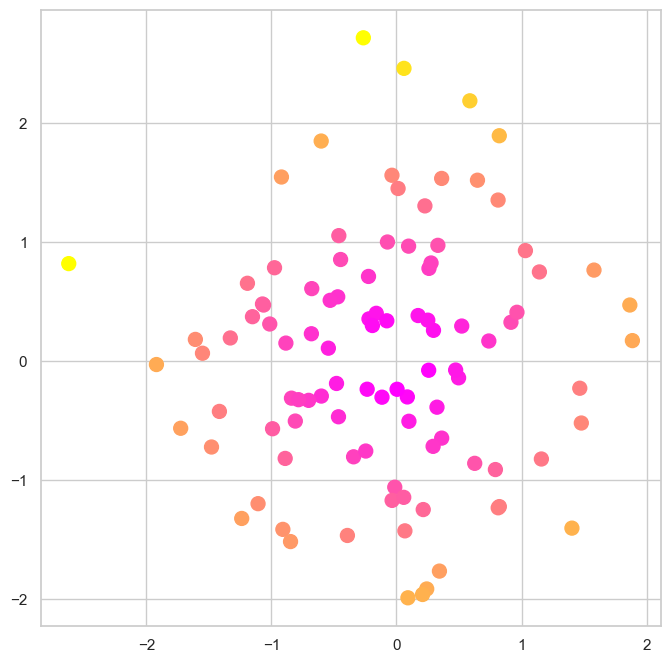

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style='whitegrid')


def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

np.random.seed(42)
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5 # 
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')




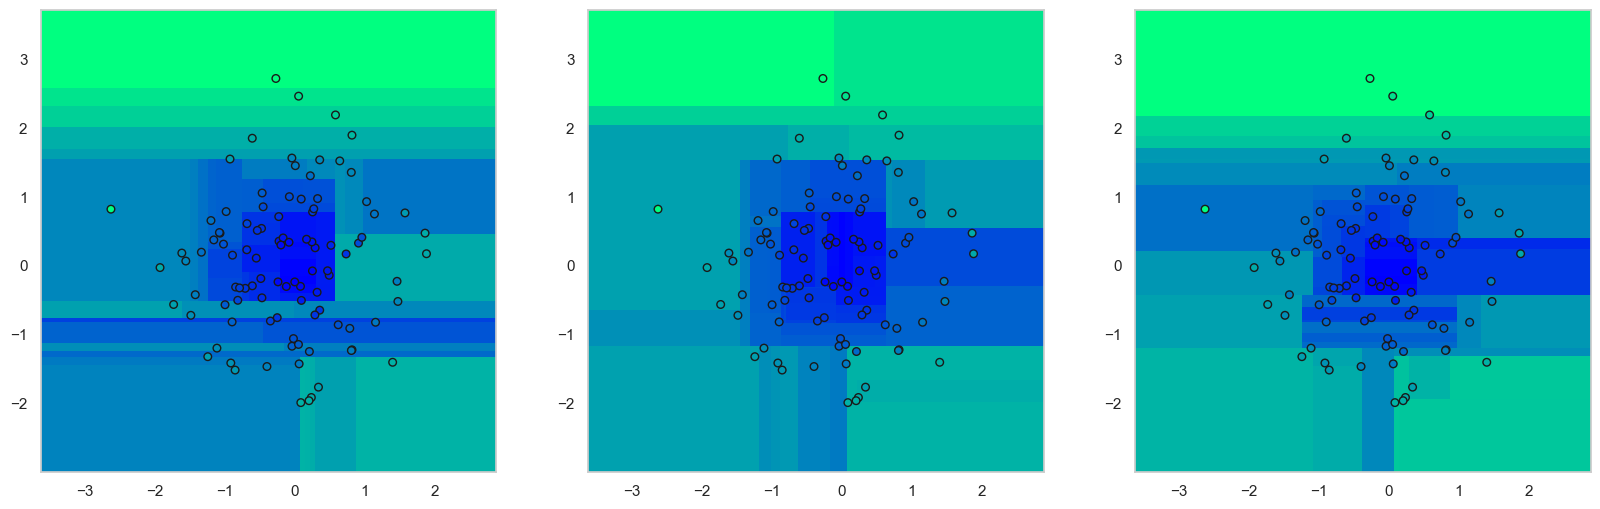

In [5]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

### Стратегии выбора остановки
1) По максимальной глубине
2) По минимальному числу объектов в листе
3) По минимальному информационному выигрышу
4) Уже тартет константный (или близок к нему)

### Отсечение ветвей (Pruning)
На примере Cost-Comlexity pruning. 

Введем штраф за размер модели:
$R_{\alpha}(T) = R(T) - \alpha * |T|$, где $|T|$ — число листьев в дереве, $\alpha$ — некоторе число от 0 до 1, а $R(T)$ — функционал качества. 
Можно построить жадную процедурц, которая будет объединять листья и минимизировать такой функционал на отложенной выборке

## Алгоритмы построения решающих деревьев
1) ID3 — простой рекурсивный способ построения решающего дерева
2) C4.5 — алгоритм, поддерживающий отсечение ветвей

## Частные случаи деревьев 
1) Симметричные деревья (oblivious decision trees) — на каждом уровне дерева используется один и тот же критерий разбиения. 
Используются в библиотеке [Catboost](https://catboost.ai/)
![odt](https://avatars.mds.yandex.net/get-yablogs/38241/file_1548410978587/orig)


2) Деревья, у которых на каждом уровне одна из вершин является листом. Используются в библиотеке [LightGBM](https://lightgbm.readthedocs.io/en/stable/).

![ldt](https://lightgbm.readthedocs.io/en/stable/_images/leaf-wise.png)

#### Ссылки:
1) [Курс ФКН ВШЭ](https://github.com/esokolov/ml-course-hse/tree/master)
    